In [106]:
"""
Qick based qubit measurement example (maybe LC tank?)

RF Out     ____~~~~~~~~~~~~~~~~~~~~. . . .~~~~~~~~~~~~~~~~~~~~___
Digitizer  ____|‾‾‾‾‾|_|‾‾‾‾‾|_|‾‾‾. . . .‾‾‾|_|‾‾‾‾‾|_|‾‾‾‾‾|___
Measured Data   IQ[0]   IQ[1]      . . . .      IQ[78]  IQ[79]
"""
import numpy as np
import math
import matplotlib.pyplot as plt
import time

from qick import *
from qick.averager_program import QickSweep
from qick.pyro import make_proxy

class LongDurationPulseExample(RAveragerProgram):
    def initialize(self):
        # Set the nyquist zone
        cfg = self.cfg
        freq_rf     = cfg["start"]
        # Declare RF generation channel
        self.declare_gen(
            ch      = 0,        # Channel
            nqz     = 2         # Nyquist Zone
        )
        # Declare RF input channel
        self.declare_readout(
            ch      = 0,        # Channel
            length  = int(cfg["pulse_time"] * 3/4) - 10,    # Readout length
                                                            # 10 is subtracted to
                                                            # make margin in timing
        )
        (self.ro_rp, self.ro_freq) = self._ro_regmap[0, "freq"]
        (self.gen_rp, self.gen_freq) = self._gen_regmap[0, "freq"]
        # Convert RF frequency to DAC DDS register value
        self.freq_dac = self.freq2reg(
            f       = freq_rf,  # Frequency
            gen_ch  = 0,        # Generator channel
            ro_ch   = 0         # Readout channel for round up
        )
        # Convert RF frequency to ADC DDS register value
        self.freq_adc    = self.freq2reg_adc(
            f       = freq_rf,  # Frequency
            ro_ch   = 0,        # Readout channel
            gen_ch  = 0         # Generator channel for round up
        )
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac, # Generator DDS frequency
            phase   = self.deg2reg(0, gen_ch = 0),        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 16,       # Dummy length
            phrst   = 0,        # Readout DDS phase reset
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.synci(100000)

    def body(self):
        cfg = self.cfg
        # Put the generator's frequency register to temporary register (page : 0, register : 6)
        self.mathi(self.gen_rp, 6, self.gen_freq, '+', 0)
        self.mathi(self.ro_rp, 6, self.ro_freq, '+', 0)
        # Make endless pulse
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = cfg["gain"],  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        # Set demodulator DDS
        self.set_readout_registers(
            ch      = 0,        # Readout channel
            freq    = self.freq_adc, # Readout DDS frequency
            length  = 1600,       # Dummy length
            phrst   = 0,        # Readout DDS phase reset
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        
        self.mathi(self.ro_rp, self.ro_freq, 6, '+', 0)
        self.readout(
            ch      = 0,        # Readout channel
            t       = 100       # Readout DDS will start multiplication
                                # @ sync_t + 100
        )
        # Make measurement triggers and shift t_sync
        for i in range(cfg["number_of_pulse"]):
            self.trigger(
                adcs    = [0],      # Readout channels
                adc_trig_offset = 150 # Readout will capture the data @ sync_t + 50
            )
            self.sync_all()
        
        self.set_pulse_registers(
            ch      = 0,            # Generator channel
            style   = "const",      # Output is envelope * gain * DDS output
            freq    = self.freq_dac,    # Generator DDS frequency
            phase   = 0,        # Generator DDS phase
            gain    = 0,  # Generator amplitude
            phrst   = 0,            # Generator DDS phase reset
            length  = 100,          # Dummy length
            mode    = "periodic",   # Set pulse mode to periodic
        )
        self.mathi(self.gen_rp, self.gen_freq, 6, '+', 0)
        self.pulse(
            ch      = 0,        # Generator channel
            t       = 100
        )
        self.sync_all(10000)
        # Make sure that do not read buffer before experiment ends
        self.wait_all()
    
    def update(self): 
        # Update readout frequency register 
        self.mathi(
            self.ro_rp, self.ro_freq, self.ro_freq, '+',
            self.freq2reg_adc(self.cfg["step"], 0, 0)
        )
        # Update generator frequency register
        self.mathi(
            self.gen_rp, self.gen_freq, self.gen_freq, '+',
            self.freq2reg(self.cfg["step"], 0, 0)
        )
        self.synci(1000)



Pyro.NameServer PYRO:Pyro.NameServer@0.0.0.0:8888
myqick PYRO:obj_897bbef126f64a46b1c2f6cefd237a4b@192.168.2.99:45373
meas time : 0.375 ms


  0%|          | 0/320 [00:00<?, ?it/s]

100%|██████████| 320/320 [00:00<00:00, 2377.05it/s]


Acquisition time for : 0.15883135795593262 s


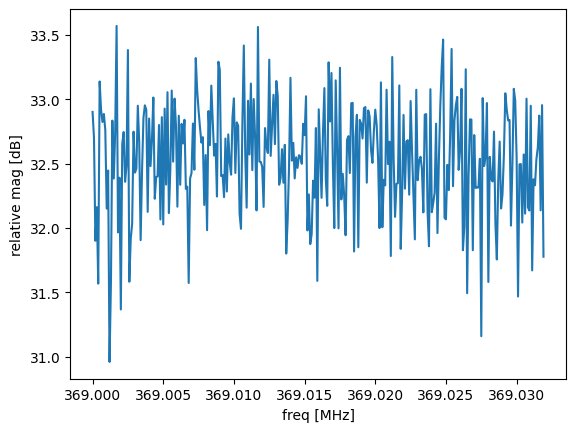

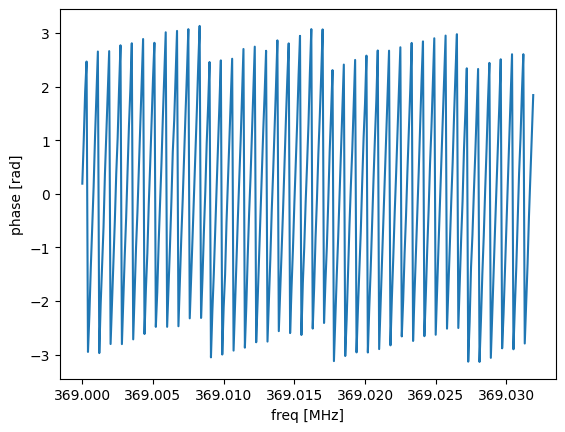

In [107]:
# Qick version : 0.2.357
(soc, soccfg) = make_proxy("192.168.2.99")
# print(soccfg)

att1 = 10
att2 = 10
# Set DAC Channel 0 attenuation 10 dB and 10 dB, and turn on DAC channel
soc.rfb_set_gen_rf(0,att1,att2)
# Set DAC Channel filter as bypass mode
soc.rfb_set_gen_filter(0,fc = 2.5, ftype = "lowpass")

# Set ADC Channel attenuation 31 dB, and turn on ADC channel
soc.rfb_set_ro_rf(0,31)
# Set ADC Channel filter as bypass mode
soc.rfb_set_ro_filter(0, fc = 2.5, ftype = "lowpass")

meas_power = {}
meas_phase = {}
meas_unwrap_phase = {}
meas_unwrap_sub_phase = {}
start_time = time.time()
cfg = {
    # Experiment Setup
    "reps" : 1,
    "expts" : 320,
    "start" : 369.0,
    "step" : 1e-4,
    "gain" : 1000,
    # Parameter Setup
    "pulse_time" : 50000,
    "number_of_pulse" : 3,
}
meas_time = cfg["pulse_time"] * cfg["number_of_pulse"] * 2.5 / 1e6
print("meas time : {:.3f} ms".format(meas_time))
prog = LongDurationPulseExample(
    soccfg,
    cfg,
)
expts, avgi, avgq  = prog.acquire(soc = soc, progress = True, start_src = "internal")
end_time = time.time()
avgi = np.array(avgi[0]).mean(axis = 0)
avgq = np.array(avgq[0]).mean(axis = 0)
meas_power = 20 * np.log10(np.sqrt(avgi * avgi + avgq * avgq))
meas_phase = np.angle(avgi + 1j * avgq)

print(f"Acquisition time for : {end_time - start_time} s")
plt.figure()
plt.ylabel("relative mag [dB]")
plt.xlabel("freq [MHz]")
plt.plot(expts, meas_power)
plt.show()

plt.figure()
plt.ylabel("phase [rad]")
plt.xlabel("freq [MHz]")
plt.plot(expts, meas_phase)
plt.show()
